The forward diffusion process adds Gaussian noise to a given image. It does so progressively and using the Markov chain, meaning that we have a noised version of the image at a timestep $t$ that depends only on the previous timestep $t-1$.

$q(x_t|x_{t-1})$ is the forward process, where an image is taken and its version with added noise is returned.
* $x_0$ is the original image
* $x_t$ is the noised version at a timestep $t$
* $\beta_t$ is the noise variance schedule which determines the amount of noise added at each timestep.
    * so a set of variances B1, B2, … BT that govern the conditional normal distributions that make up the Markov chain
    * the scheduler from the paper has 1000 time steps of linearly increasing variances starting at 1e-4 to 0.02

The whoel forward process is a sequence where we gradually map our data X to pure noise:
* $Norm_{z_t}[\sqrt{1-\beta_t}z_{t-1}, \beta_tI]$ for each $t$

The forward process is statis, meaning that we choose the noise schedule as a hyperparameter to the diffusion model and we don't train the forward process as it is already defined.

One key property is that we can sample $x_t$ directly at any timestep given the original image $x_0$. Here $\bar a_t$ is introduced as $1-\beta$ and it's accumulated version that is the product of all $\bar a_t$'s. This servers as a colse-form solutions for simpler implementation. Or explained as:

"The final key detail we have to know about the forward process is that because the distributions are normal, we can mathematically derive a distribution known as the “Diffusion Kernel” which is the distribution of any intermediate value in our forward process given our initial data point. This allows us to bypass all of the intermediate steps of iteratively adding t-1 levels of noise in the forward process to get an image with t noise which will come in handy later when we train our model. This is mathematically represented as: $q(z_t|x) = Norm_{z_t}[\sqrt{a_t}* x,(1- a_t)I]$. "

In [28]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# Defining the transformations; images are converted to [0,1] range and scaled to [-1, 1]
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# # Loading the MNIST training data
# mnist_trainset = datasets.MNIST(root='./', train=True, download=True, transform=transform)
# data_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)

# Loading the MNIST test data
# mnist_testset = datasets.MNIST(root='./', train=False, download=True, transform=None)

# from: https://www.datascienceweekly.org/tutorials/pytorch-mnist-load-mnist-dataset-from-pytorch-torchvision

In [30]:
def forward_diffusion_sample(x_0, t, alpha_bar):
    """
    This function samples x_t from q(x_t | x_0) by taking the original image, a timestep and a precomputed cumulative product. It returns an image with added Gaussian noise.

    """
    # creating Gaussian noise; x_0 size tensor of random numbers from a uniform distribution [0,1)
    noise = torch.randn_like(x_0)
    
    # computing the scaling factors
    sqrt_alpha_bar_t = torch.sqrt(alpha_bar[t]).view(-1, 1, 1, 1)   # this information tells us how much of the original image remains after t steps of noising
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar[t]).view(-1, 1, 1, 1) # .view() changes the shape so that it fits (batch size, channels, height, width)

    # forward process formula
    x_t = sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * noise

    return x_t, noise

So now the closed-form solution for sampling $x_t$ given $x_0$ is implemented: $x_t = \sqrt{\bar \alpha_t} x_0 + \sqrt{1 - \bar \alpha_t} * \epsilon $.
Here, $\epsilon$ follows a normal distribution with mean 0 and std of 1.
The intuition is that at each timestep $t$, the image is scaled down by the first scaling factor, and noise is added scalled by the second scalling factor.

In [31]:
# Defining the parameters as described in the paper

T = 1000  # number of diffusion steps
beta = torch.linspace(0.0001, 0.02, T)  # linear scheduler 
alpha = 1.0 - beta
alpha_bar = torch.cumprod(alpha, dim=0)  # cumulative product of alphas at each timestep t

In [32]:
# alpha_bar
sqrt_alpha_bar_t = torch.sqrt(alpha_bar[2])
sqrt_alpha_bar_t

tensor(0.9998)

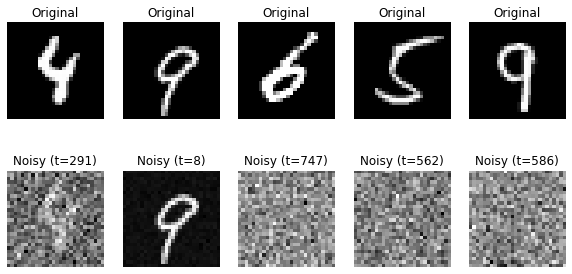

In [33]:
# printing random images at random timesteps
for batch in data_loader:
    x_0, _ = batch
    t = torch.randint(0, T, (x_0.size(0),))
    x_t, _ = forward_diffusion_sample(x_0, t, alpha_bar)
    
    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x_0[i].squeeze().cpu().numpy(), cmap='gray')
        plt.title("Original")
        plt.axis('off')
        
        plt.subplot(2, 5, i + 6)
        plt.imshow(x_t[i].squeeze().cpu().numpy(), cmap='gray')
        plt.title(f"Noisy (t={t[i].item()})")
        plt.axis('off')
    plt.show()
    break